In [79]:
import xarray as xr
import matplotlib.pyplot as plt
import properscoring as ps
import numpy as np
import os

# --- ⚙️ 설정 변수 ---
# 1. 분석할 .nc 파일 경로
nc_file_path = '/data03/SAM/AI_storm_emulator_CorrDiff/generate_output/corrdiff_autoregressive_output.nc'

# 2. 시각화할 변수 이름
variable_to_plot = 'W'

# 3. 결과물 저장 폴더
output_dir = 'visualization_results'

# 4. 저장할 최종 이미지 파일 이름
output_filename = 'res_autoregressive_forecast_comparison.png'
# ---------------------

# 결과물 저장 폴더가 없으면 생성
os.makedirs(output_dir, exist_ok=True)
print(f"결과물은 '{output_dir}' 폴더에 저장됩니다.")

# --------------------------------------------------
# Data Dimensions
# Input: (Time, X, Y, Channel)
# Truth: (Time, Step, X, Y, Channel)
# Unet : (Time, Step, X, Y, Channel)
# Pred : (Ens , Time, Step, X, Y, Channel)
# --------------------------------------------------

try:
    # --- 1. 데이터 로딩 ---
    # ds = xr.open_dataset(nc_file_path)
    ds_truth = xr.open_dataset(nc_file_path, group='truth', decode_times=False)
    ds_pred = xr.open_dataset(nc_file_path, group='prediction', decode_times=False)
    ds_res = xr.open_dataset(nc_file_path, group='regression', decode_times=False)
    ds_coords = xr.open_dataset(nc_file_path, decode_times=False)
    ds_input = xr.open_dataset(nc_file_path, group='input', decode_times=False)
    
    lat = ds_coords['lat'].values[16:-16,16:-16]
    lon = ds_coords['lon'].values[16:-16,16:-16]

    # 전체 타임스텝 개수 확인
    num_times = ds_pred.sizes['time']
    num_steps = ds_pred.sizes['step']
    print(f"총 {num_times}개의 초기장에 대한 {num_steps}단계 시각화를 시작합니다.")




except FileNotFoundError:
    print(f"❌ Error: '{nc_file_path}' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

결과물은 'visualization_results' 폴더에 저장됩니다.
총 5개의 초기장에 대한 5단계 시각화를 시작합니다.


전체 데이터의 값 범위 (min/max): 37.26 / 50.53
✅ 모든 타임스텝을 포함한 그림이 'visualization_results/res_autoregressive_forecast_comparison.png' 파일로 저장되었습니다.


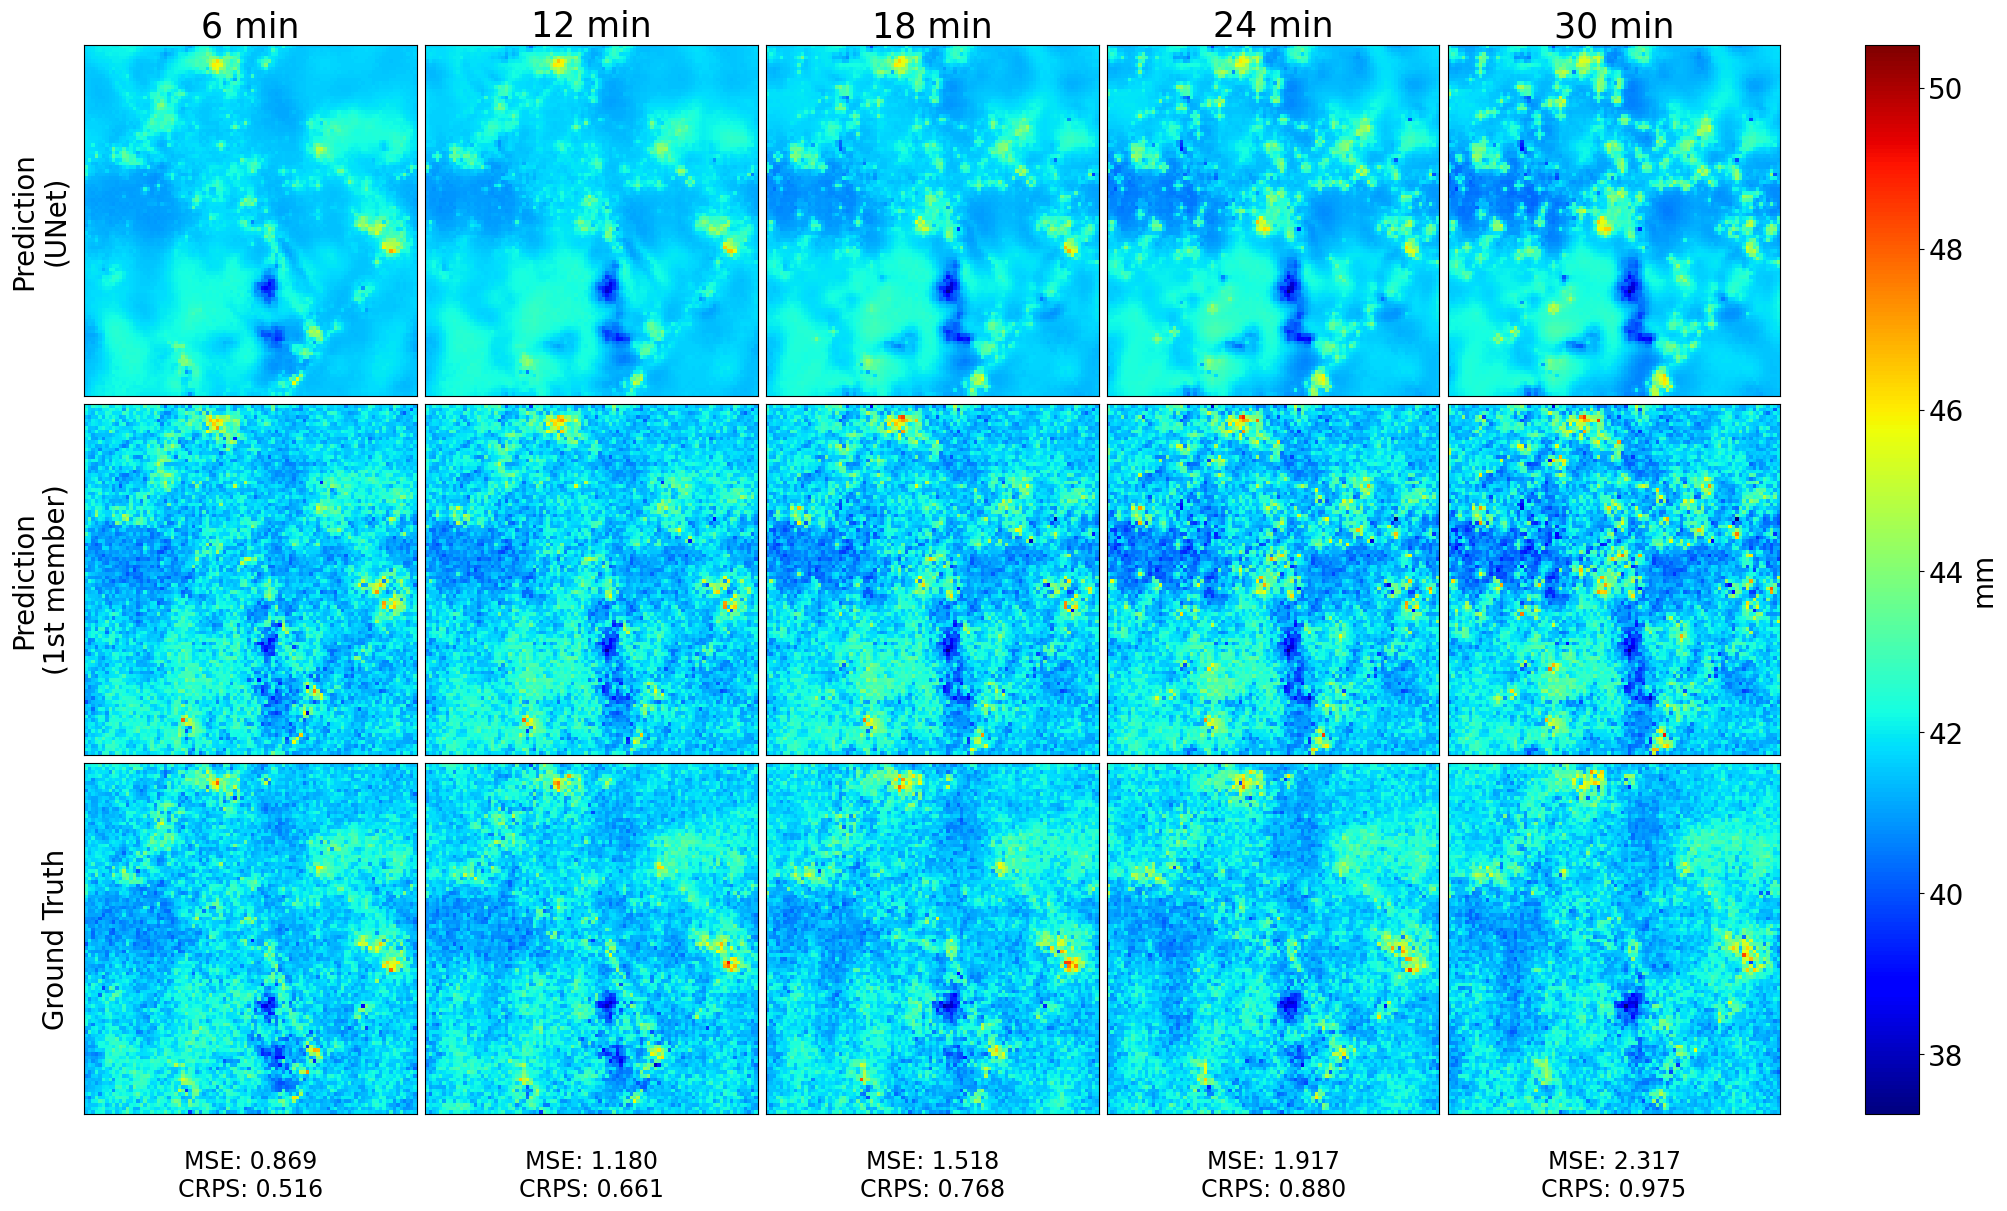

✅ 모든 타임스텝을 포함한 그림이 'visualization_results/res_autoregressive_forecast_comparison.png' 파일로 저장되었습니다.


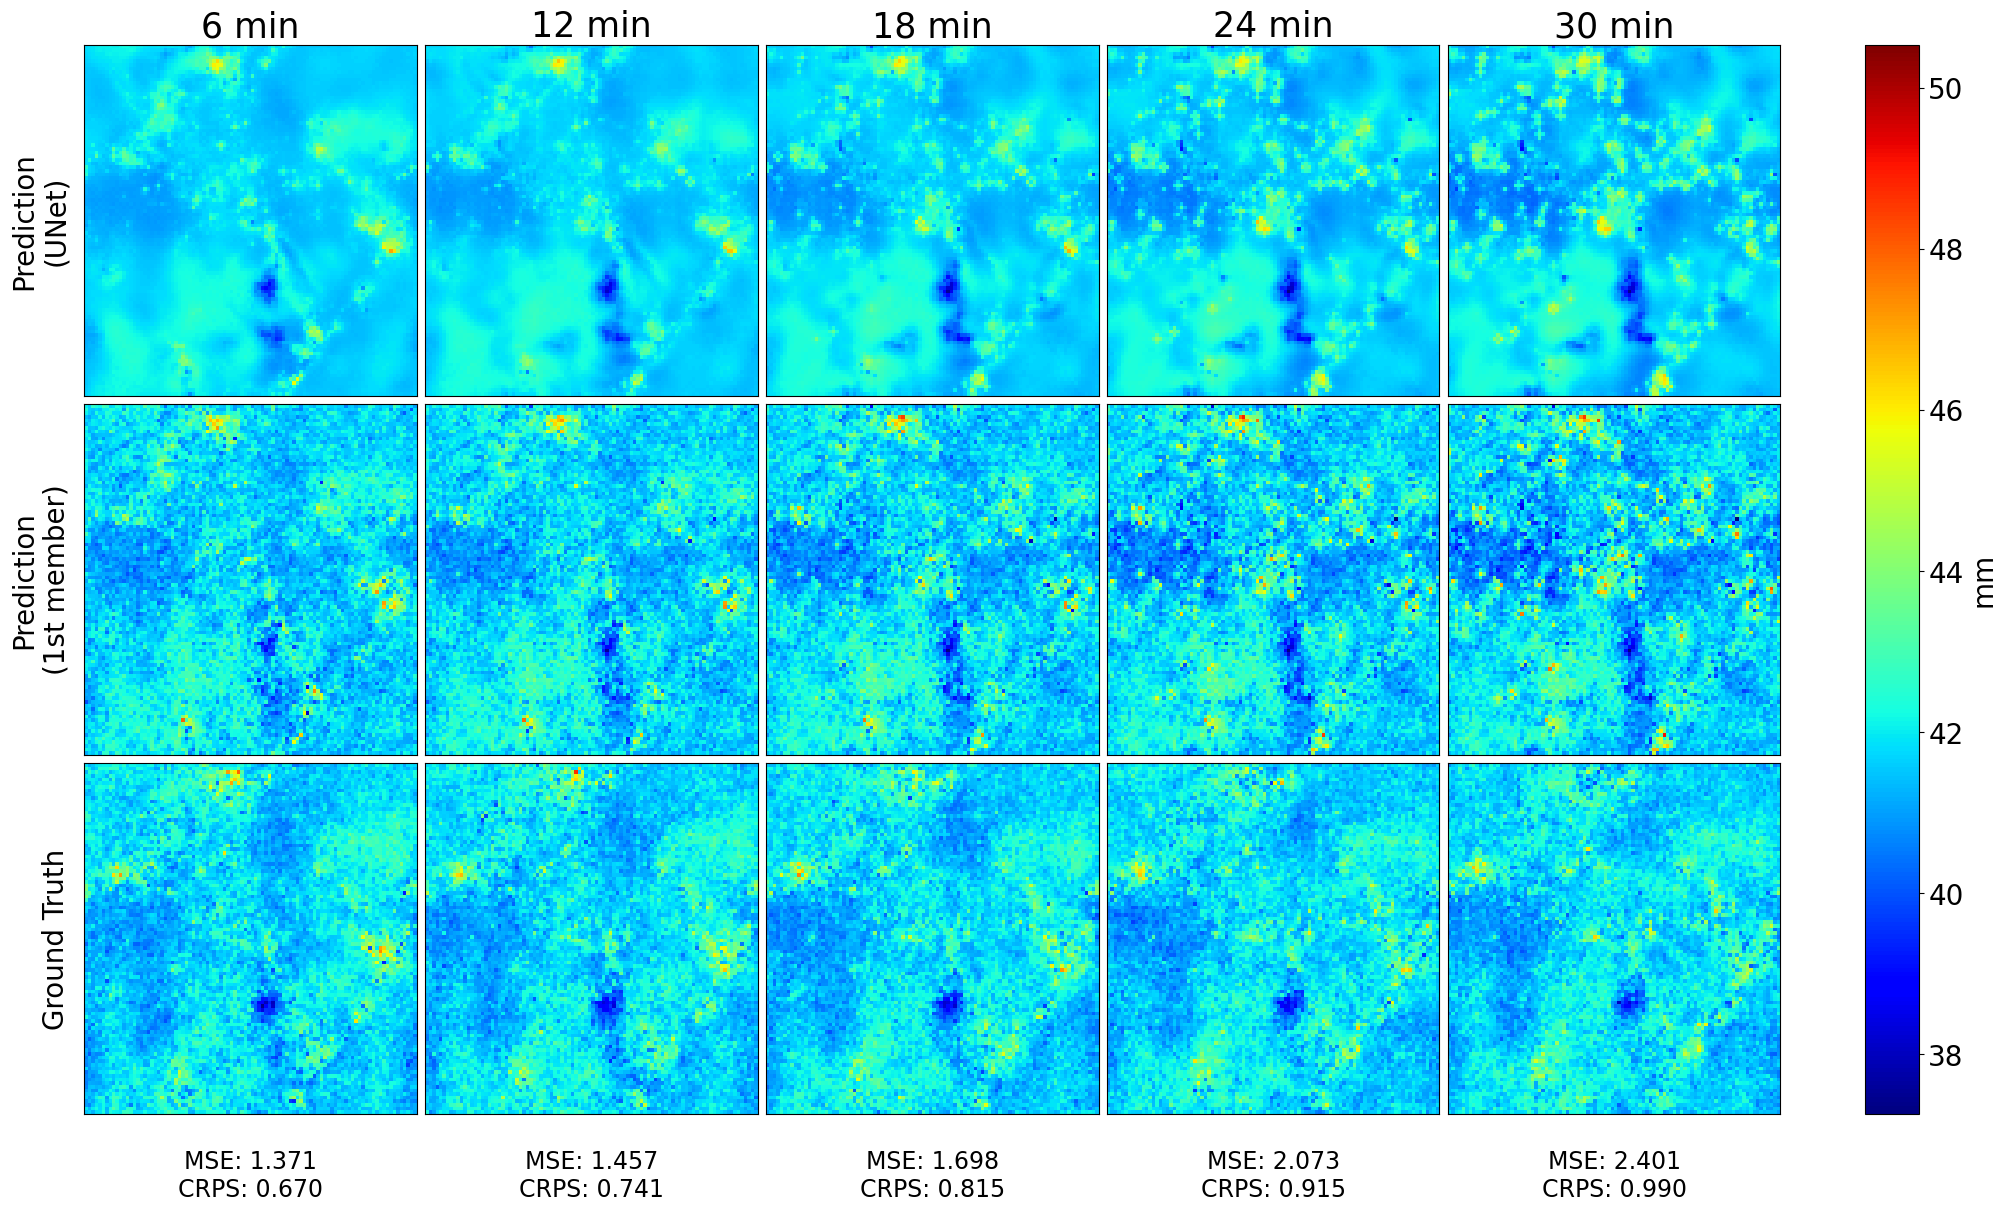

✅ 모든 타임스텝을 포함한 그림이 'visualization_results/res_autoregressive_forecast_comparison.png' 파일로 저장되었습니다.


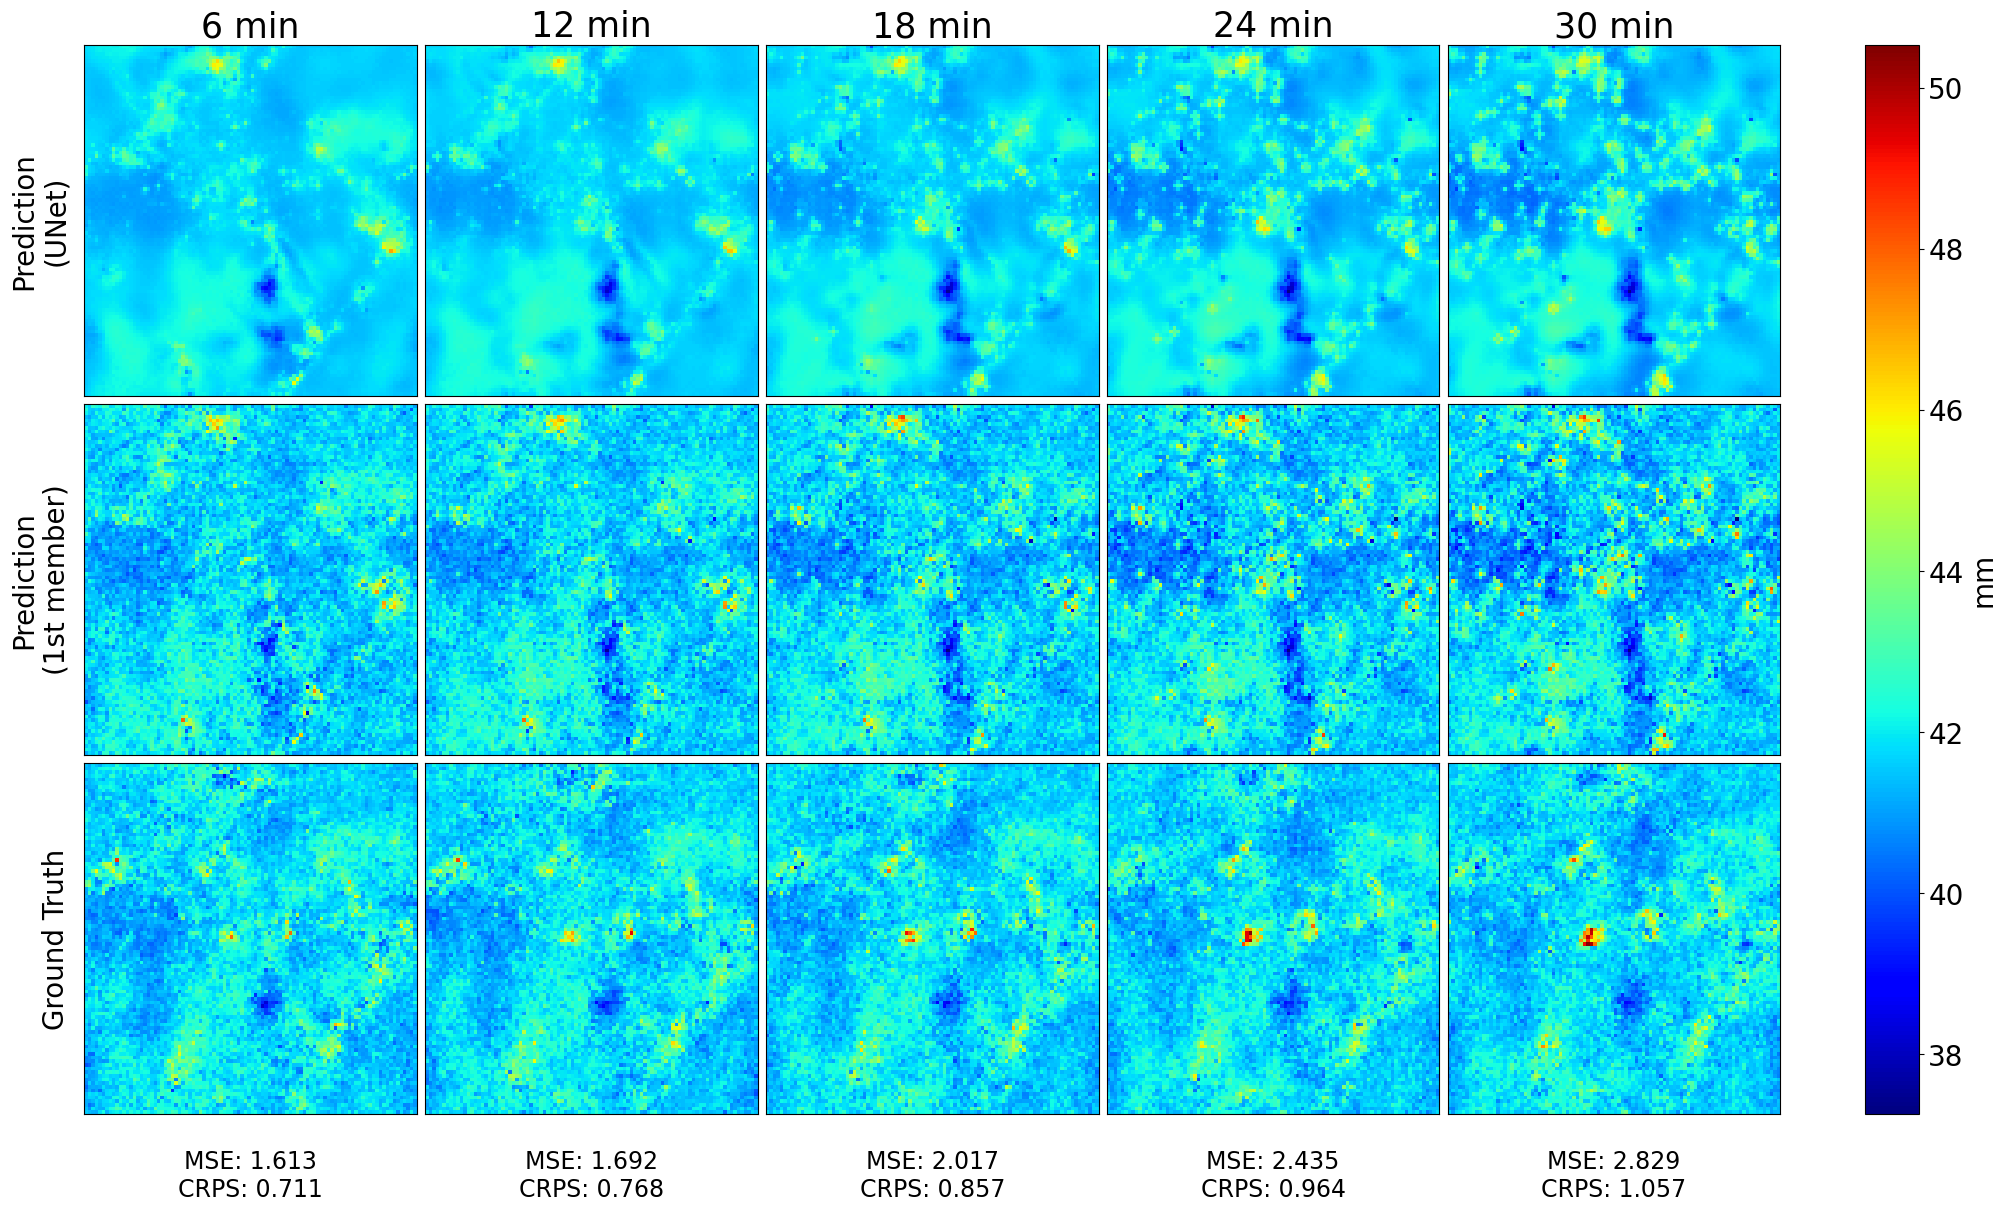

In [80]:
#Bring the mean and std data for normalization
file_path = "/data03/SAM/input_data/2D/W_1m/mean_std_100d_1m.npy"
arr = np.load(file_path)
mean = arr[0][0]
std = arr[1][0]


# --- 3. 전체 플롯에 대한 공통 컬러맵 범위 계산 ---
# 모든 데이터에 걸쳐 최소/최대값을 계산하여 색상 범위를 통일합니다.
min_val = ds_truth[variable_to_plot].min()
max_val = ds_truth[variable_to_plot].max()
min_val = min_val * std + mean
max_val = max_val * std + mean
print(f"전체 데이터의 값 범위 (min/max): {min_val.item():.2f} / {max_val.item():.2f}")


# for time in range(num_times):
for time in range(3):
    # # --- 2. 시각화할 전체 데이터 준비 ---
    # # 모든 타임스텝의 truth와 prediction 데이터를 미리 불러옵니다.
    all_truth_data = ds_truth[variable_to_plot].isel(time=time)[...,16:-16,16:-16]
    all_pred_data_1st_member = ds_pred[variable_to_plot].isel(time=time, ensemble=1)[...,16:-16,16:-16]
    all_pred_data_ensembles = ds_pred[variable_to_plot].isel(time=time)[...,16:-16,16:-16]
    all_res_data = ds_res[variable_to_plot].isel(time=time)[...,16:-16,16:-16]



    # --- 4. 💡 하나의 큰 Figure 생성 ---
    # 3행 num_timesteps열의 그리드를 만듭니다. figsize로 전체 그림 크기를 조정합니다.
    fig, axes = plt.subplots(
        nrows=3, 
        ncols=num_steps, 
        figsize=(4 * num_steps, 12), 
        constrained_layout=True
    )

    mse_scores = []
    crps_scores = []

    # --- 5. 💡 각 subplot에 데이터 채우기 ---
    # 각 열(timestep)을 순회하며 그림을 그립니다.
    for s_idx in range(num_steps):
        # MSE score
        mse = np.mean((all_pred_data_1st_member.isel(step=s_idx).values - all_truth_data.isel(step=s_idx).values)**2)
        mse_scores.append(mse)

        # CRPS score
        crps = ps.crps_ensemble(all_truth_data.isel(step=s_idx).values, all_pred_data_ensembles.isel(step=s_idx).values, axis=0).mean()
        crps_scores.append(crps)

        # print(f"--- 타임스텝 {s_idx} ---")
        # print(f"  - MSE:  {mse:.4f}")
        # print(f"  - CRPS: {crps:.4f}")    

        # 1행: Prediction (UNet)
        ax_res = axes[0, s_idx]
        im = ax_res.pcolormesh(lon, lat, all_res_data.isel(step=s_idx)*std + mean, 
                                vmin=min_val, vmax=max_val, cmap='jet', shading='auto')
        ax_res.set_xticks([]) # x축 눈금 제거
        ax_res.set_yticks([]) # y축 눈금 제거
        ax_res.set_title(f'{(s_idx+1)*6} min', fontsize = 25) # 각 열의 제목 (시간 인덱스)

        # 2행: Prediction (1st member)
        ax_pred = axes[1, s_idx]
        ax_pred.pcolormesh(lon, lat, all_pred_data_1st_member.isel(step=s_idx)*std + mean, 
                            vmin=min_val, vmax=max_val, cmap='jet', shading='auto')
        ax_pred.set_xticks([]) # x축 눈금 제거
        ax_pred.set_yticks([]) # y축 눈금 제거
        
        # 3행: Ground Truth
        ax_truth = axes[2, s_idx]
        ax_truth.pcolormesh(lon, lat, all_truth_data.isel(step=s_idx)*std + mean, 
                            vmin=min_val, vmax=max_val, cmap='jet', shading='auto')
        ax_truth.set_xticks([]) # x축 눈금 제거
        ax_truth.set_yticks([]) # y축 눈금 제거

        # --- 💡💡💡 수정한 부분: 점수 텍스트 추가 💡💡💡 ---
        # 3행 그래프(ax_truth)를 기준으로 아래쪽에 텍스트를 추가합니다.
        score_text = f"MSE: {mse:.3f}\nCRPS: {crps:.3f}"
        ax_truth.text(0.5, -0.1, score_text, 
                        ha='center',       # 수평 정렬: 중앙
                        va='top',          # 수직 정렬: 텍스트 상자 상단 기준
                        fontsize=17, 
                        transform=ax_truth.transAxes) # 좌표 기준: ax_truth 영역

    # --- 6. 💡 행(Row) 제목 설정 ---
    # 첫 번째 열에만 각 행의 제목을 표시합니다.
    axes[0, 0].set_ylabel('Prediction\n(UNet)', fontsize=20, labelpad=10)
    axes[1, 0].set_ylabel('Prediction\n(1st member)', fontsize=20, labelpad=10)
    axes[2, 0].set_ylabel('Ground Truth', fontsize=20, labelpad=10)

    # --- 7. 💡 전체 Figure에 대한 공통 설정 ---
    # fig.suptitle(f'Autoregressive Forecast vs. Ground Truth for "{variable_to_plot}"', fontsize=25)

    # 그림 오른쪽에 공통 컬러바 추가
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label=f'{variable_to_plot} units')
    cbar.ax.tick_params(labelsize=20)  # 컬러바 눈금 폰트 크기 조정
    cbar.set_label(f'mm', fontsize=20)  # 컬러바 레이블 폰트 크기 조정

    # 최종 이미지 파일로 저장
    save_path = os.path.join(output_dir, output_filename)
    plt.savefig(save_path, dpi=300)
    print(f"✅ 모든 타임스텝을 포함한 그림이 '{save_path}' 파일로 저장되었습니다.")

    plt.show()
# plt.close(fig)

In [75]:
ds_res[variable_to_plot].isel(time=0, step = 0)[...,16:-16,16:-16] - ds_res[variable_to_plot].isel(time=2, step = 0)[...,16:-16,16:-16]
# ds_truth[variable_to_plot].isel(time=1, step = 3)[...,16:-16,16:-16] - ds_truth[variable_to_plot].isel(time=2, step = 3)[...,16:-16,16:-16]

<xarray.DataArray 'W' (y: 96, x: 96)> Size: 37kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(96, 96), dtype=float32)
Dimensions without coordinates: y, x